In [24]:
import numpy as np
import matplotlib.pyplot as plt
import math as math
import pandas as pd
from scipy.integrate import simps
from scipy.integrate import odeint


'__Definición de funciones__'

def find_nearest(array, value):
    '''
    Recibe un array y un valor; devuelve el valor más cercano al recibido
    '''
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return array[idx-1]
    else:
        return array[idx]

def find_nearest_pos(array, value):
    '''
    Recibe un array y un valor; devuelve el índice del elemento con el valor más cercano al recibido
    '''
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return idx-1
    else:
        return idx

def eqX(y):
    '''
    Devuelve concentración de equilibrio en fase sólida a partir de una concentración en fase líquida
    '''
    KeqX = [15.80011045, 32.02907632, 5.735438305, 0.053726466, 1.972131456]
    eqX = KeqX[0]*KeqX[1]*y/(1+KeqX[1]*y)+KeqX[2] * KeqX[3]*(y-KeqX[4])/(1-KeqX[3]*(y-KeqX[4]))
    return eqX

def m(y):
    '''
    Devuelve el valor del coeficiente de distribución para una determinada concentración en fase líquida
    '''
    m = y/eqX(y)
    return m

def Bi(y):
    '''
    Calcula el número de Biot en función de una concentración
    '''
    Bi = m(y)*kL*a/Deff
    return Bi    

def batch(X, t):
    '''
    '''
    x = X[0]
    y = X[1]
    dxdt = K * (eqX(y)-x) / (1-eps)
    dydt = -K * (eqX(y) - x) / eps
    return [dxdt, dydt]

def column(F, t):
    '''
    Toma los valores iniciales de una matriz (F) y devuelve la discretizacion en el espacio del balance de masa en una columna
    '''
    x = F[::2]
    y = F[1::2]
    y[0] = 0

    dFdt = np.empty_like(F)

    dxdt = dFdt[::2]
    dydt = dFdt[1::2]
    
    '____________________________________________________________________________________________'

     # A lo largo de todo el extractor la variación de concentración
     # en el sólido en función del tiempo es igual a la
     # ecuación de transferencia de masa

    dxdt[:] = K * (eqX(y[:]) - x[:]) / (1-eps)

    '____________________________________________________________________________________________'

     # En z = 0 ingresa el solvente, por lo que se considera que no hay acumulación en ese punto

    dydt[0] = 0
    
     # A lo largo del extractor la variación se puede considerar la ecuación general
    difusion = eps * Dax * np.diff(y[:], 2)/dz**2
    conveccion = uz * np.diff(y[:-1], 1)/dz
    transferencia = K * (eqX(y[1:-1]) - x[1:-1])


    dydt[1:-1] = (difusion - conveccion - transferencia)/eps

    dydt[-1] = (eps*Dax*(2*y[-2]-2*y[-1]) - uz *
                (y[-1]-y[-2])/dz - K*(eqX(y[-1]) - x[-1]))/eps

    '____________________________________________________________________________________________'

    return dFdt

def countercurrent(F, t):
    '''
    '''
    x = F[::2]
    y = F[1::2]

    x[-1] = porcentajeAC*dens
    y[0]= 0.01

    dFdt = np.empty_like(F)

    dxdt = dFdt[::2]
    dydt = dFdt[1::2]

    '____________________________________________________________________________________________'

    # En el punto de ingreso de sólidos (z = L) no hay variación en función del tiempo
    dxdt[-1] = 0
    
    # A lo largo del extractor se considera la ecuación general
    conveccionS = S/A * np.diff(x[1:], 1)/dz
    transferenciaS = K * (eqX(y[1:-1]) - x[1:-1])
    dxdt[1:-1] = (conveccionS + transferenciaS) / (1-eps)

    dxdt[0] = + (S/A *(x[1]-x[0])/dz +  K * (eqX(y[0])-x[0])) / (1-eps)

    '____________________________________________________________________________________________'

    # A lo largo del extractor se considera la ecuación general
    dydt[-1] =  ( -uz * (y[-1]-y[-2])/dz - K * (eqX(y[-1])-x[-1])) / (eps)
    
    difusionL = eps * Dax * np.diff(y[:], 2)/dz**2
    conveccionL = uz * np.diff(y[:-1], 1)/dz
    transferenciaL = K * (eqX(y[1:-1]) - x[1:-1])

    dydt[1:-1] = (difusionL - conveccionL - transferenciaL)/eps

    # En el punto de ingreso de solvente (z = 0) se considera que no hay acumulación
    dydt[0] = 0

    '____________________________________________________________________________________________'

    return dFdt

def error_porcentual(modelo):

    error_porcentual = 0

    for i, dato in enumerate(concentracion_experimental):

        tiempo = tiempo_experimental[i]
        posicion_t = find_nearest_pos(t/60,tiempo)
        
        error = abs((modelo[posicion_t, 1]-dato)/dato)
        error_porcentual += error

    return error_porcentual/(i+1)*100


'__Fuente de gráficos__'
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = '9'


'__Datos Cinéticos Experimentales'
tiempo_experimental = [1,5,10,15,30,46,80,108,142,168,192,1263,1608]                             # min
concentracion_experimental = [0.11,0.21,0.3,0.46,0.72,0.93,1.3,1.37,1.59,1.62,1.58,1.64,1.76]    # g/L
datos_experimentales = [[tiempo_experimental],[concentracion_experimental]]


kb = 1.38*10**-23 # Constante de Boltzmann
e = math.e
pi = math.pi

# Estimación viscosidades
T = 25 + 273

# Definición de propiedades
porcentajeAC = 0.06             # Porcentaje de Ácido Carnósico
dens = 557.82                   # Densidad del sólido
densb = 180                     # Densidad del lecho
densL = 935.69                  # Densidad de fase líquida
Deff = (1.3*(10**-10))/60       # Difusividad efectiva en sólido
phi = 2.012453362               # Factor de forma
a = 0.000706498099              # Longitud característica
ap = 3362                       # Área equivalente
Deq = 6/ap                      # Diámetro equivalente a esfera
eps = 1.-densb/dens             # Porosidad del lecho

# Propiedades estimadas
viscH2O = e**(
                - 52.843 + 3703.6/T
                + 5.866*math.log(T)
                - 5.98*10**(-29)*(T)**10
            )
viscEtOH = e**(
                7.875+781.98/T
                - 3.0418*math.log(T)
                ) 
visc = 0.01
rad = math.pow(326.5*(3/(4*pi)), 1/3)*10**(-10)                     # radio molecular de van der waals
Dab = kb*T/(6*pi*visc*rad)                                          # Ecuación de Einstein para difusividad

# Definición de parámetros de diseño
L = 4.421                                                           # Longitud del equipo
Dc = 0.35                                                            # Diámetro del equipo
A = math.pi*(Dc/2)**2                                               # Área del equipo

# Definición de parámetros de proceso
W = 1000/(3600*7*5*4)                                               # Materia prima a tratar, por hora (7 horas, 5 días, 4  semanas)
L = 2 * (W*3600*7)/densb/A                                          # Multiplico por dos porque en el neto trato una sola columna por día
S = 1.072*10**-6                                                    # Flujo volumétrico de sólidos (m³/s)
nu = A*L*eps/(3*3600)/2                                             # Flujo volumétrico de solvente (m³/s)
tau = 6*3600                                                        # Tiempo máximo a calcular en la simulación



# Estimación de números adimensionales y coeficientes
uz = nu/(A)                                                         # Velocidad lineal de solvente
Re = uz*Deq*densL/(visc*(1-eps))                                    # Número de Reynolds
Pe = 0.2/eps + 0.011/eps + math.pow(eps*Re, 0.48)                   # Número de Peclet
Sc = visc/(densL*Dab)                                               # Numero de Schmidt   
ShL = (0.765/(Re**0.82) + 0.365/(Re**0.386))*Re*(Sc**(1/3))/eps     # Número de Sherwood
Dax = Deq*uz/(eps*Pe)                                               # Dispersión axial
kL = ShL*Dab/a                                                      # Transferencia de masa en fase líquida

# Definición de la constante global de transferencia de masa
K = 8.07*10**-9
K = K*ap


# Cálculo de tiempos de residencia para el líquido y el sólido
resTime = A*L*eps/nu
resTimeS = A*L*(1-eps)/S


In [25]:
# Print de datos
print(f'''Propiedades:
Porcentaje de ácido carnósico:              {porcentajeAC*100}\t %
Densidad del sólido:                        {dens:.3f}\t Kg/m³
Densidad del lecho:                         {densb}\t    Kg/m³
Densidad de fase líquida:                   {densL:.3}\t Kg/m³
Difusividad efectiva:                       {Deff:.3}\t m²/s
Factor de forma:                            {phi:.3}
Longitud característica:                    {a:.3}\tm
Área específica:                            {ap}\t1/m
Diámetro equivalente:                       {Deq:.3}\tm
Porosidad del lecho:                        {eps:.3}
''')

print(f'''Propiedades Estimadas:
Viscosidad                                  {visc:.3}        Pa.s
Radio van der waals:                        {rad:.3}    m
''')

print(f'''Parámetros de diseño:
Largo total de equipo:                      {L:.3}    m
Diámetro de contacto:                       {Dc:.3}    m
''')

print(f'''Parámetros de proceso:
Flujo materia prima:                        {S*dens*3600:.3} \t Kg/h
Flujo de solvente:                          {nu*3600:.3} \t m³/h
''')

print(f'''Parámetros:
Velocidad lineal:                           {uz:.3}    m/s
Reynolds:                                   {Re:.3}
Peclet:                                     {Pe:.3}
Schmidt:                                    {Sc:.3}
SherwoodL:                                  {ShL:.3}    
Dax:                                        {Dax:.3}\tm²/s
Dab:                                        {Dab:.3}\tm²/s
kL:                                         {kL:.3}\tm/s
Bi:                                         {Bi(15):.3}''')

print('\n\n')
print(f'Masa de sólido por hora:            {round(S*3600*dens,2):.3f}    Kg/h')
print(f'Volumen de solvente por hora:       {round(nu*3600*1000,2):.3f}    L/h')
print(f'Tiempo de residencia de líquido:    {round(resTime/3600,2):.3f}    h')
print(f'Tiempo de residencia de sólido:     {round(resTimeS/3600,2):.3f}    h')
print('\n\n')








Propiedades:
Porcentaje de ácido carnósico:              6.0	 %
Densidad del sólido:                        557.820	 Kg/m³
Densidad del lecho:                         180	    Kg/m³
Densidad de fase líquida:                   9.36e+02	 Kg/m³
Difusividad efectiva:                       2.17e-12	 m²/s
Factor de forma:                            2.01
Longitud característica:                    0.000706	m
Área específica:                            3362	1/m
Diámetro equivalente:                       0.00178	m
Porosidad del lecho:                        0.677

Propiedades Estimadas:
Viscosidad                                  0.01        Pa.s
Radio van der waals:                        4.27e-10    m

Parámetros de diseño:
Largo total de equipo:                      5.77    m
Diámetro de contacto:                       0.35    m

Parámetros de proceso:
Flujo materia prima:                        2.15 	 Kg/h
Flujo de solvente:                          0.0627 	 m³/h

Parámetros:
Velocidad line

In [26]:
'____Cálculos____'

# Número de puntos
nz = 300
nt = tau


# Condiciones iniciales
eqLiq = 16.03

Z = np.linspace(0, L, nz)         
t = np.linspace(0*3600, tau, nt)

dz = Z[1] - Z[0]
dt = t[1] - t[0]

F0 = np.ones(2*nz)

F0[0::2] = porcentajeAC*dens
F0[1::2] = eqLiq



equip = 'SC'
sol = odeint(column, F0, t, ml=1, mu=2)



FF = np.ones_like(F0)
sol[-1, ::] = F0[::]
rendimientos = []

for i in range(0,5):

    FF[0:300:2] = sol[-1, 300:600:2]
    FF[1:301:2] = sol[-1, 301:600:2]

    FF[300:600:2] = porcentajeAC*dens
    FF[301:600:2] = eqLiq

    sol = odeint(column,FF, t, ml=1, mu=2)
    rendimiento_solido = 1 - (sol[-1,:300:2].mean()/(porcentajeAC*dens))
    rendimientos.append(rendimiento_solido)



# Separo los resultados en una variable para
# las concentraciones en el sólido y otra para
# las concentraciones en el líquido

X = sol[:, ::2]
Y = sol[:, 1::2]
rendimiento_solido = 1 - (X[-1,:150].mean()/(porcentajeAC*dens))





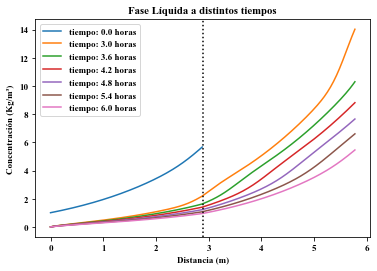

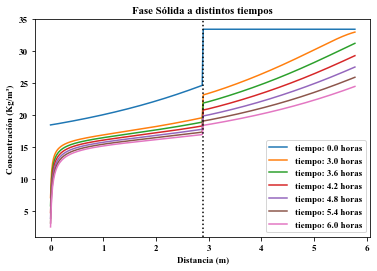

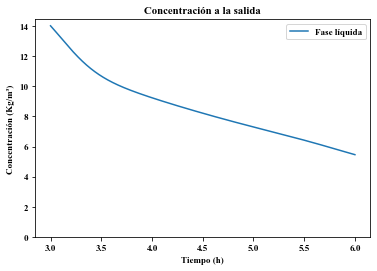


Concentración promedio: 8.56
Concentración final: 5.46
rendimiento_solido: 0.5449727243236862



In [27]:
'__Obtención de gráficos__'


# Definición de un tiempo inicial para analizar y el máximo índice de z
tiniPos = find_nearest_pos(t, resTime/2)    # Divido el tiempo de residencia por dos porque son dos columnas y a la mitad del tiempo ya pasó el tiempo inicial de la segunda
zEnd = int(nz)
zHalf = int(nz/2)

# Concentración a la salida del extractor
Yin = Y[:, 1]
Yout = Y[:, -1]
Xin = X[:, -1]
Xout = X[:, 1]
Concentración promedio: 8.56
Concentración final: 5.46
rendimiento_solido: 0.5449727243236862
# Obtengo tiempos a los cuales deseo extraerles información
tiempos = [0]
for i in range(tiniPos, int(nt), int((nt-tiniPos)/5)):
    tiempos.append(i)

# Grafico concentraciones de fase líquida
for i in tiempos:
    if i == 0:
        plt.plot(Z[:zHalf], Y[i, :zHalf], label=f'tiempo: {round(t[i]/3600, 1)} horas')
        None
    else:
        plt.plot(Z[:], Y[i, :], label=f'tiempo: {round(t[i]/3600, 1)} horas')

plt.title('Fase Líquida a distintos tiempos')
plt.xlabel('Distancia (m)')
plt.ylabel('Concentración (Kg/m³)')
plt.axvline(x=Z[zHalf], color="black", linestyle=':')
plt.legend()
plt.show()


# Grafico concentraciones de fase sólida
for i in tiempos:
    plt.plot(Z[:zEnd], X[i, :zEnd], label=f'tiempo: {round(t[i]/3600, 1)} horas')

plt.title('Fase Sólida a distintos tiempos')
plt.xlabel('Distancia (m)')
plt.ylabel('Concentración (Kg/m³)')
plt.axvline(x=Z[zHalf], color="black", linestyle=':')
plt.legend()
plt.show()


# Grafico concentración a la salida del extractor
plt.plot(t[tiniPos:]/3600, Yout[tiniPos:], label='Fase líquida')
plt.title('Concentración a la salida')
plt.xlabel('Tiempo (h)')
plt.ylabel('Concentración (Kg/m³)')
plt.ylim(ymin=0)
plt.legend()
plt.show()


concentracion_promedio = Yout[tiniPos:].mean()

print(f'''
Concentración promedio: {round(concentracion_promedio,2)}
Concentración final: {round(Yout[-1],2)}
rendimiento_solido: {rendimiento_solido}
''')


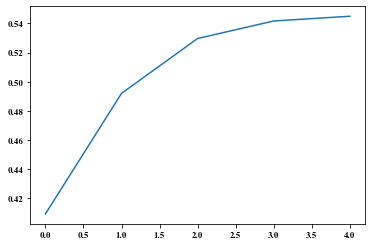

In [28]:
plt.plot(rendimientos)